In [75]:
import pandas as pd
import glob
import os
import re
from io import StringIO

## Load in data

In [76]:
# Define the directory containing the .txt files
directory_path = '../../../leonia_etho_data'  # Replace with your directory path

# Define the glob pattern
file_pattern = os.path.join(directory_path, 'Track-Julia_Gq_locomotion_frombelow-Trial*.txt')

# Use glob to get all matching file paths
file_paths = glob.glob(file_pattern)

In [77]:
def extract_key_from_filename(filename):
    """
    Extracts a clean key from the filename by removing the prefix and replacing spaces with underscores.
    Example:
        Input: 'Track-Julia_Gq_locomotion_frombelow-Trial    39-Arena 2-Subject 1.txt'
        Output: 'Trial39-Arena2-Subject1'
    """
    # Remove the directory and extension
    base = os.path.splitext(os.path.basename(filename))[0]
    
    # Remove the fixed prefix
    prefix = 'Track-Julia_Gq_locomotion_frombelow-'
    if base.startswith(prefix):
        base = base[len(prefix):]
    
    # Replace spaces with underscores and remove any trailing characters if necessary
    key = re.sub(r'\s+', '', base)
    
    return key

In [78]:
import pandas as pd
import re
from io import StringIO

def parse_txt_file(file_path):
    """
    Parses the given .txt file into a header dictionary and a pandas DataFrame.

    Returns:
        header_dict (dict): Dictionary containing header key-value pairs.
        data_df (pd.DataFrame): DataFrame containing the trial data.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Initialize header_lines list
    header_lines = []
    data_start_line_index = None

    # Iterate over lines to find the ' ' line
    for idx, line in enumerate(lines):
        stripped_line = line.strip().rstrip(',')
        if stripped_line == '" "':
            # Found the separator line
            data_start_line_index = idx + 1  # Data starts after the column names and units
            break
        else:
            header_lines.append(line)

    if data_start_line_index is None:
        raise ValueError(f"Could not find the separator ' ' line in {file_path}")

    # Next two lines are column names and units
    col_names_line = lines[data_start_line_index]
    units_line = lines[data_start_line_index + 1]
    data_start_line_index += 2  # Data starts after these two lines

    # Extract column names and units
    col_names = re.findall(r'"(.*?)"', col_names_line.strip())
    units = re.findall(r'"(.*?)"', units_line.strip())

    # Combine column names and units
    if len(col_names) != len(units):
        raise ValueError("Number of column names and units do not match")
    new_col_names = []
    for name, unit in zip(col_names, units):
        if unit:
            new_name = f"{name} ({unit})"
        else:
            new_name = name
        new_col_names.append(new_name)

    # Parse header lines into header_dict
    header_dict = {}
    for line in header_lines:
        # Remove any trailing commas and whitespace
        line = line.strip().rstrip(',')
        if not line or line == '" "':
            continue  # Skip empty lines or lines with just a space
        # Split the line into key and value
        parts = re.findall(r'"(.*?)"', line)
        if len(parts) == 2:
            key, value = parts
            header_dict[key] = value
        elif len(parts) == 1:
            # Handle lines with only a key (no value)
            key = parts[0]
            header_dict[key] = None
        else:
            # Handle unexpected formats
            print(f"Unexpected header format in line: {line}")

    # The remaining lines after header are data
    data_lines = lines[data_start_line_index:]

    # Combine data lines into a single string for pandas
    data_str = ''.join(data_lines)

    # Use StringIO to read the data with pandas
    data_io = StringIO(data_str)

    # Read the data into a DataFrame
    # Added index_col=False to ensure the first column is not used as index
    try:
        data_df = pd.read_csv(
            data_io,
            delimiter=',',
            quotechar='"',
            header=None,           # No header in data
            names=new_col_names,   # Use the new column names
            skipinitialspace=True,
            index_col=False        # Ensure the first column is not used as index
        )
    except pd.errors.ParserError as e:
        print(f"Error parsing {file_path}: {e}")
        data_df = pd.DataFrame()  # Return empty DataFrame on error

    return header_dict, data_df


In [79]:
# Initialize the main dictionary
data_store = {}

for file_path in file_paths:
    key = extract_key_from_filename(file_path)
    header, df = parse_txt_file(file_path)
    data_store[key] = {
        'header': header,
        'data': df
    }

# Example: Accessing data for a specific key
# print(data_store['Trial39-Arena2-Subject1']['header'])
# print(data_store['Trial39-Arena2-Subject1']['data'])

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def create_heatmap(df, body_part, trial_header):
    """
    Create a heatmap for a specified body part's X and Y coordinates.

    Parameters:
    - df: The pandas DataFrame containing the trial data.
    - body_part: The body part for which to generate the heatmap (e.g., 'nose', 'center', 'tail').
    """

    genotype = trial_header['Genotype']
    mouse_id = trial_header['mouse ID']
    treatment = trial_header['Treatment']
    arena_id = trial_header['Arena ID']
    
    suffix = f'''
    genotype: {genotype},
    mouse_id: {mouse_id},
    treatment: {treatment}
    arena_id: {arena_id}'''

    # Define the X and Y column names based on the body part
    x_col = f'X {body_part} (cm)'
    y_col = f'Y {body_part} (cm)'

    # Ensure the body part exists in the DataFrame
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError(f"Columns for body part '{body_part}' not found in the DataFrame")

    # Extract the X and Y data, dropping NaN values
    x_data = df[x_col].dropna()
    y_data = df[y_col].dropna()

    # Create a 2D histogram (heatmap) of the X and Y data
    heatmap, xedges, yedges = np.histogram2d(x_data, y_data, bins=20)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(
        heatmap.T, 
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        origin='lower',
        cmap='viridis',
        aspect='auto'
    )
    plt.colorbar(label='Density')
    plt.title(f'Heatmap of {body_part.capitalize()} Movement,{suffix}')
    plt.xlabel('X Position (cm)')
    plt.ylabel('Y Position (cm)')
    plt.savefig(f'{genotype}_{mouse_id}_{treatment}_{arena_id}_{body_part}.png')
    plt.show()

# Example usage:
# Assuming 'df' is your DataFrame
# create_heatmap(df, 'nose')

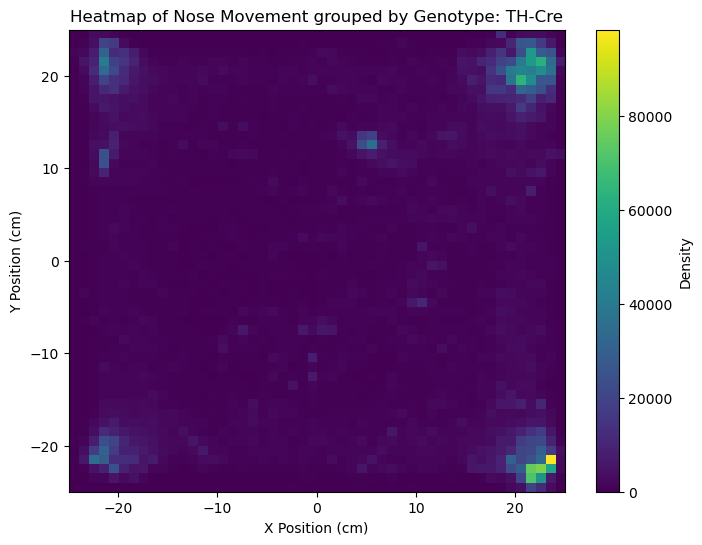

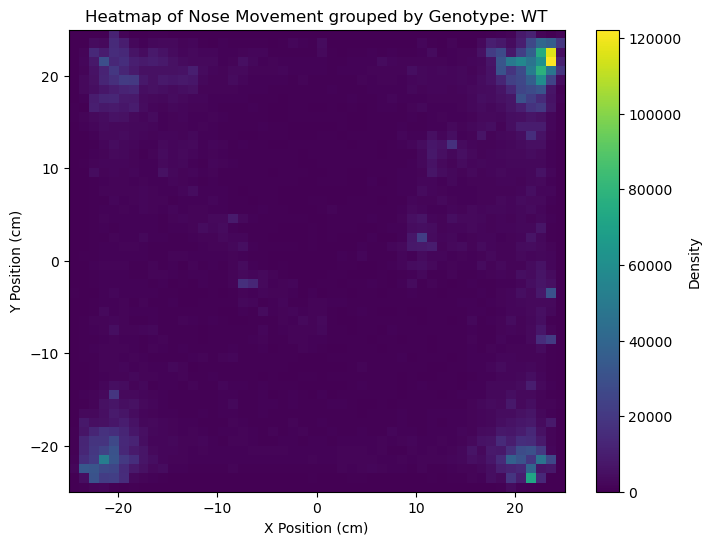

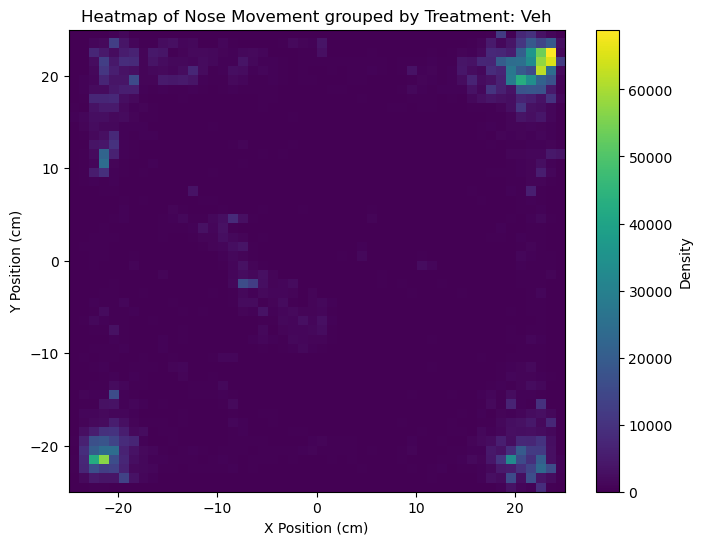

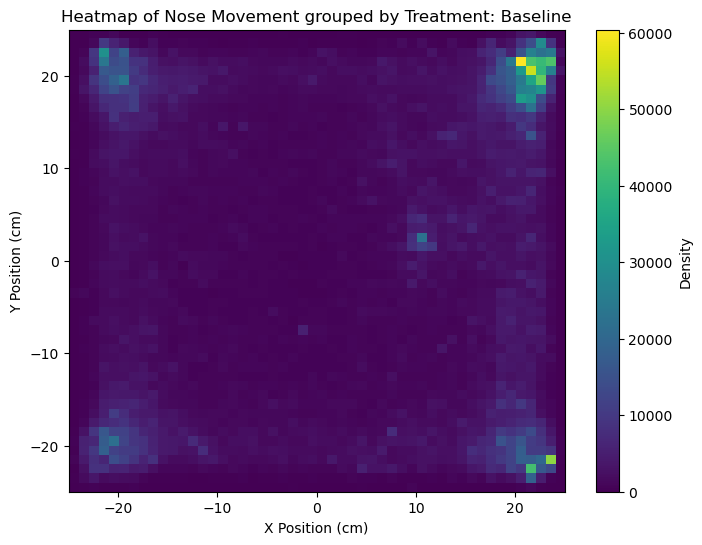

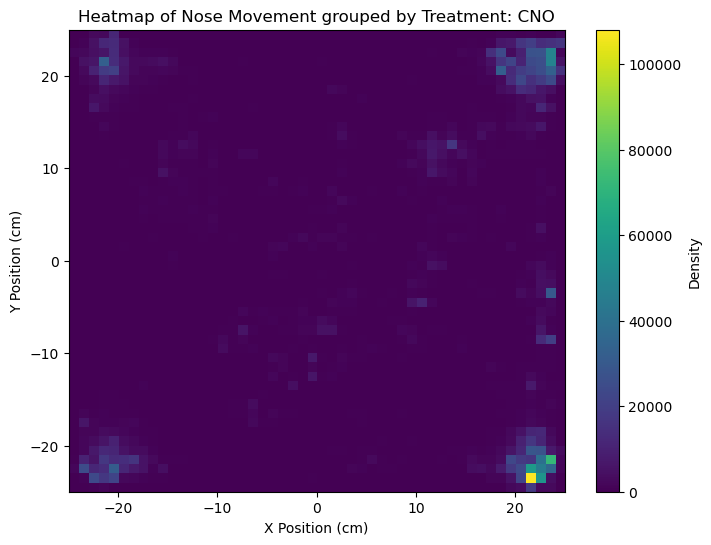

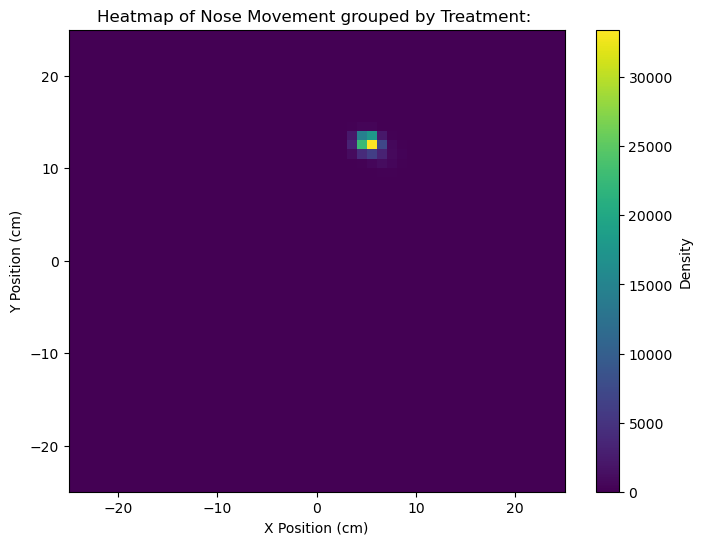

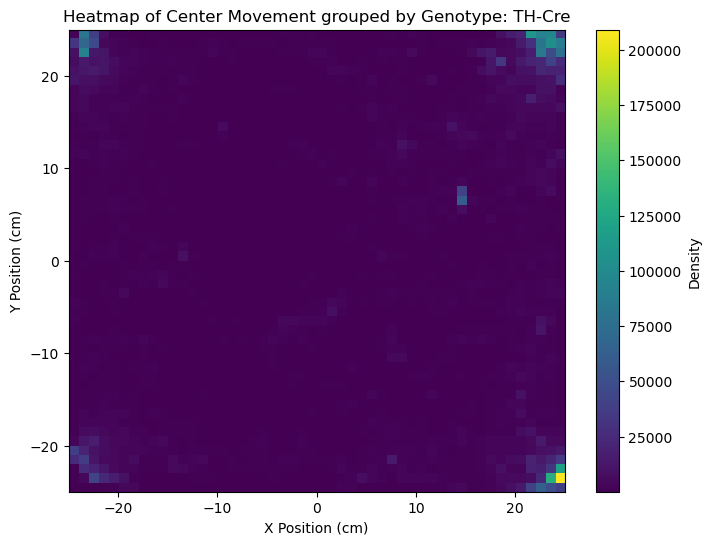

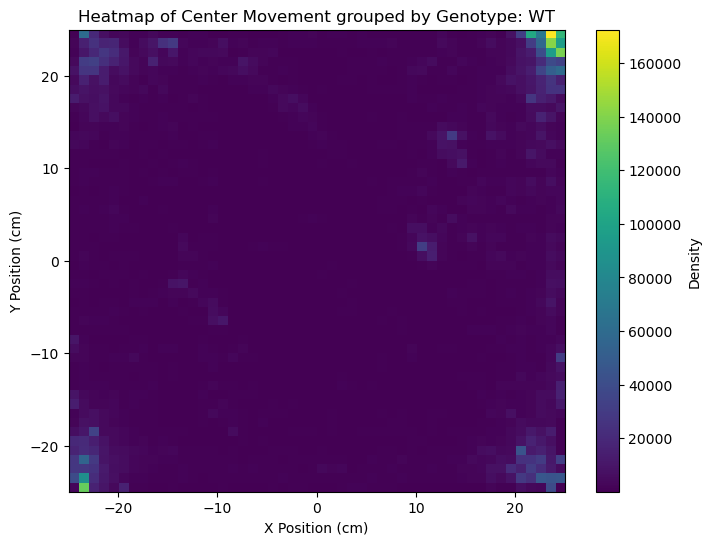

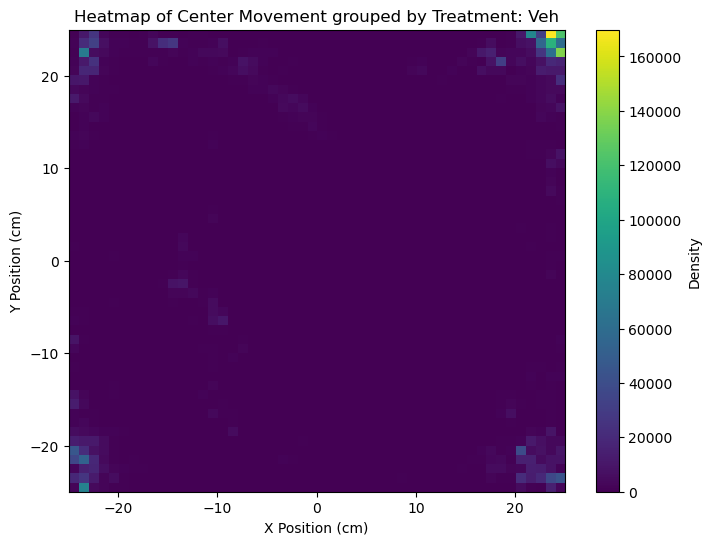

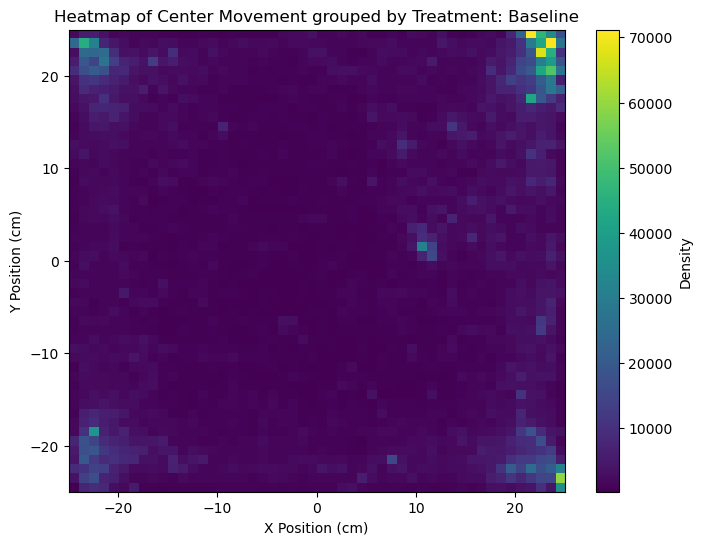

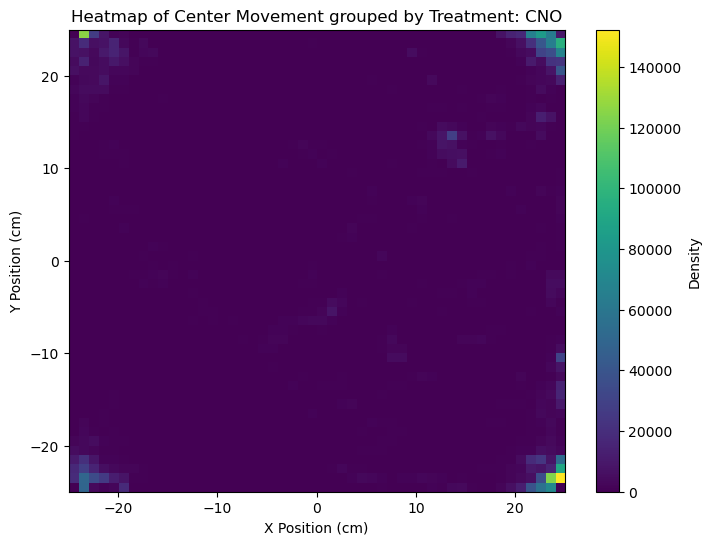

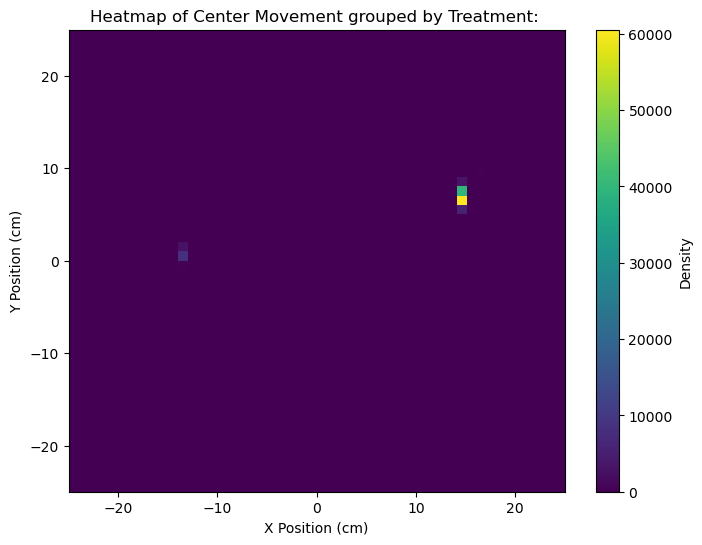

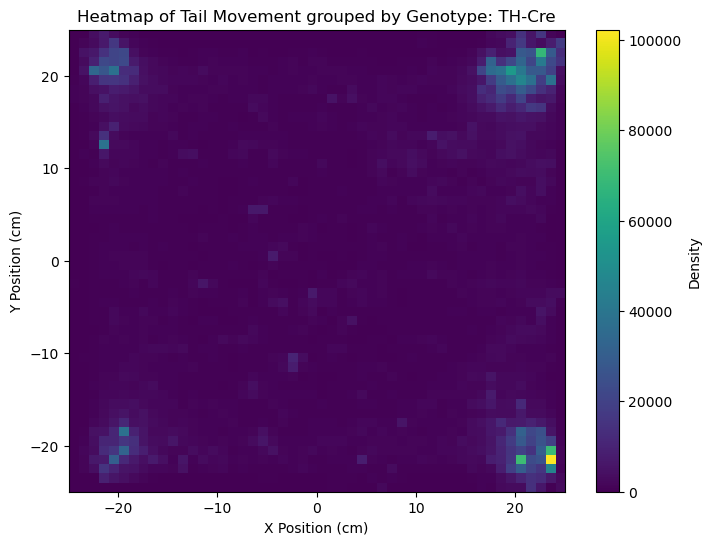

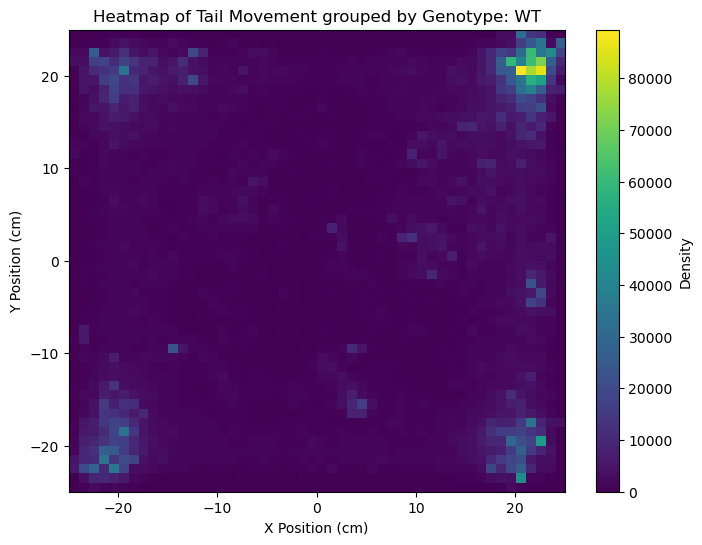

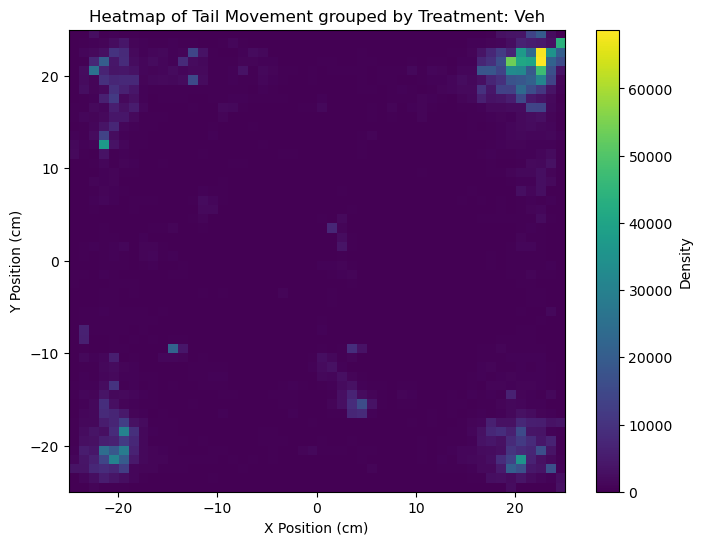

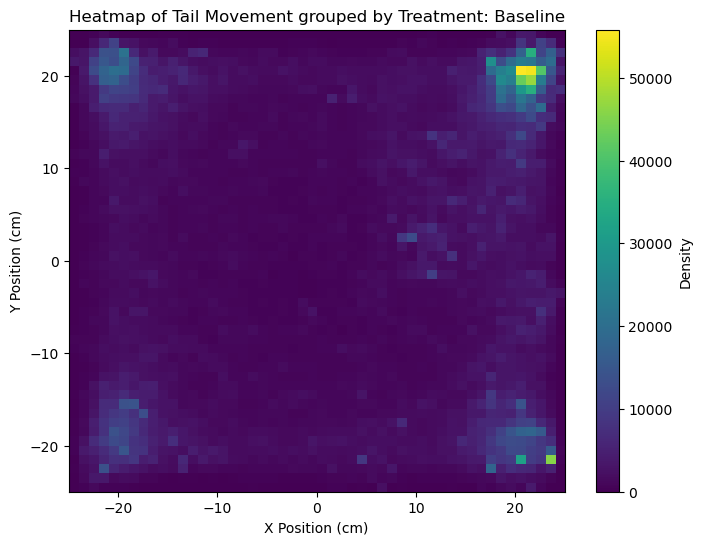

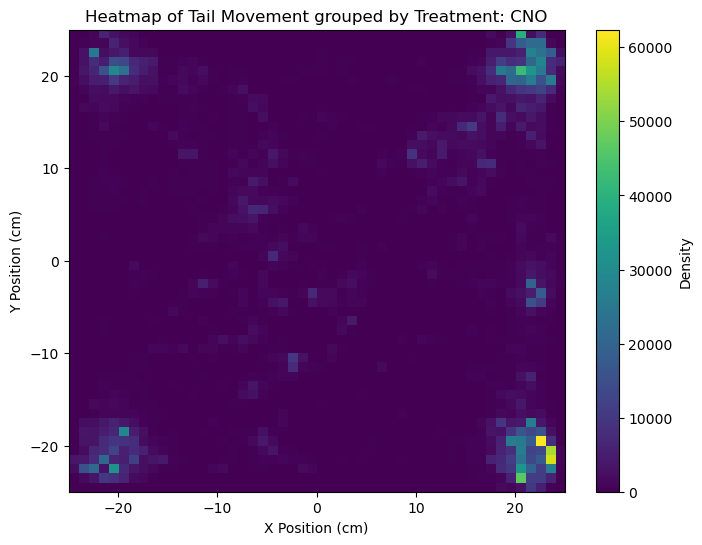

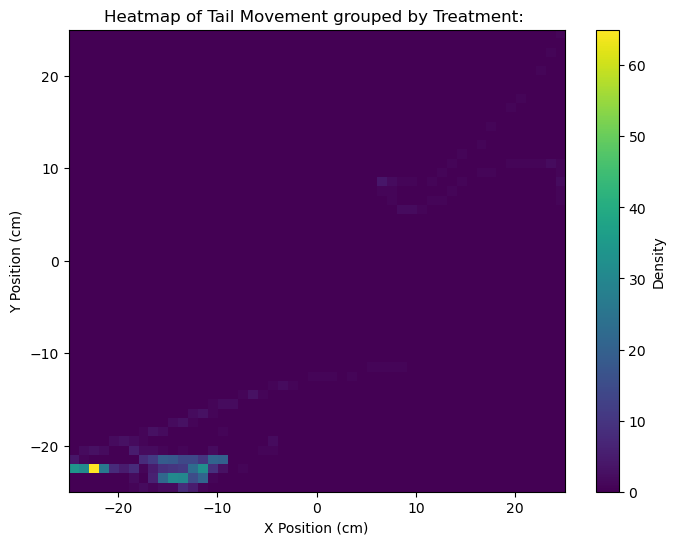

In [90]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_data(df, x_col, y_col, x_min_target=-25, x_max_target=25, y_min_target=-25, y_max_target=25):
    """
    Normalize the X and Y data to fit within the target coordinate range (-25, 25).
    """
    x_data = df[x_col].dropna()
    y_data = df[y_col].dropna()

    # Find the current min and max of the data
    x_min, x_max = x_data.min(), x_data.max()
    y_min, y_max = y_data.min(), y_data.max()

    # Scale the data to fit the target range
    x_data_scaled = (x_data - x_min) / (x_max - x_min) * (x_max_target - x_min_target) + x_min_target
    y_data_scaled = (y_data - y_min) / (y_max - y_min) * (y_max_target - y_min_target) + y_min_target

    return x_data_scaled, y_data_scaled

def create_grouped_heatmap(data_store, group_by, body_part):
    """
    Create grouped heatmaps based on the specified group (e.g., genotype, treatment, etc.).

    Parameters:
    - data_store: A dictionary containing trial data and headers.
    - group_by: The key to group by in the header (e.g., 'Genotype', 'Treatment').
    - body_part: The body part for which to generate the heatmap (e.g., 'nose', 'center', 'tail').
    """

    grouped_data = {}

    for trial, trial_data in data_store.items():
        trial_df = trial_data['data']
        trial_header = trial_data['header']
        group_key = trial_header[group_by]

        # Define the X and Y column names based on the body part
        x_col = f'X {body_part} (cm)'
        y_col = f'Y {body_part} (cm)'

        if x_col not in trial_df.columns or y_col not in trial_df.columns:
            continue  # Skip trials that don't have the relevant columns

        # Normalize the data to fit within the target range (-25, 25)
        x_data_scaled, y_data_scaled = normalize_data(trial_df, x_col, y_col)

        # Initialize the group if it doesn't exist
        if group_key not in grouped_data:
            grouped_data[group_key] = {'x': [], 'y': []}

        # Append the scaled data for this trial to the corresponding group
        grouped_data[group_key]['x'].extend(x_data_scaled)
        grouped_data[group_key]['y'].extend(y_data_scaled)

    # Create a heatmap for each group
    for group_key, data in grouped_data.items():
        x_data = np.array(data['x'])
        y_data = np.array(data['y'])

        # Create a 2D histogram (heatmap) of the X and Y data
        heatmap, xedges, yedges = np.histogram2d(x_data, y_data, bins=50, range=[[-25, 25], [-25, 25]])

        # Plot the heatmap
        plt.figure(figsize=(8, 6))
        plt.imshow(
            heatmap.T, 
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            origin='lower',
            cmap='viridis',
            aspect='auto'
        )
        plt.colorbar(label='Density')
        plt.title(f'Heatmap of {body_part.capitalize()} Movement grouped by {group_by}: {group_key}')
        plt.xlabel('X Position (cm)')
        plt.ylabel('Y Position (cm)')
        plt.savefig(f'heatmap_{group_by}_{group_key}_{body_part}.png')
        plt.show()

# Example usage:
# Create heatmaps grouped by 'Genotype' for the 'nose'
for body_part in ['nose', 'center', 'tail']:
    create_grouped_heatmap(data_store, group_by='Genotype', body_part=body_part)
    create_grouped_heatmap(data_store, group_by='Treatment', body_part=body_part)


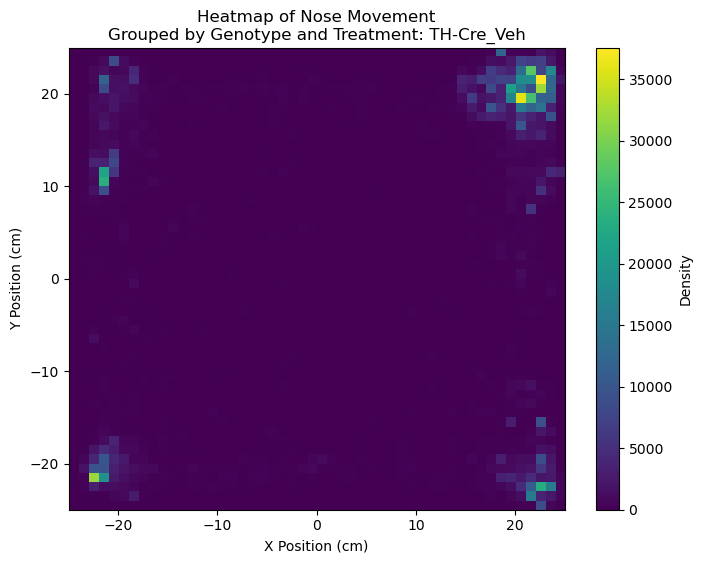

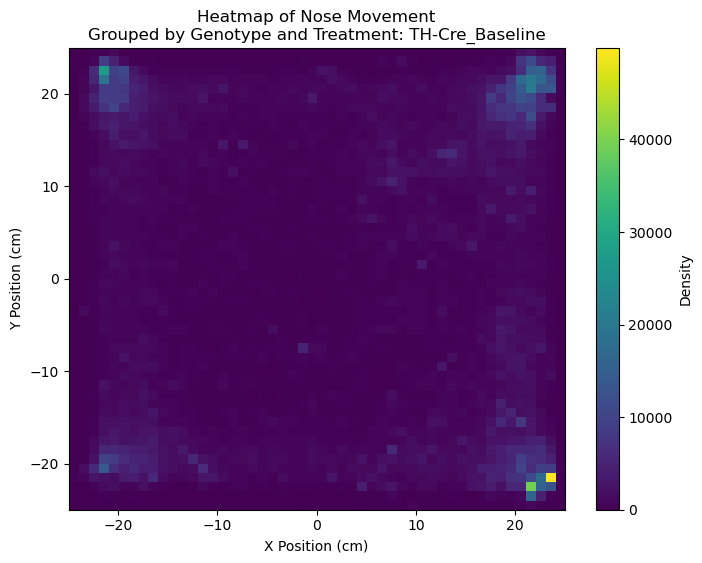

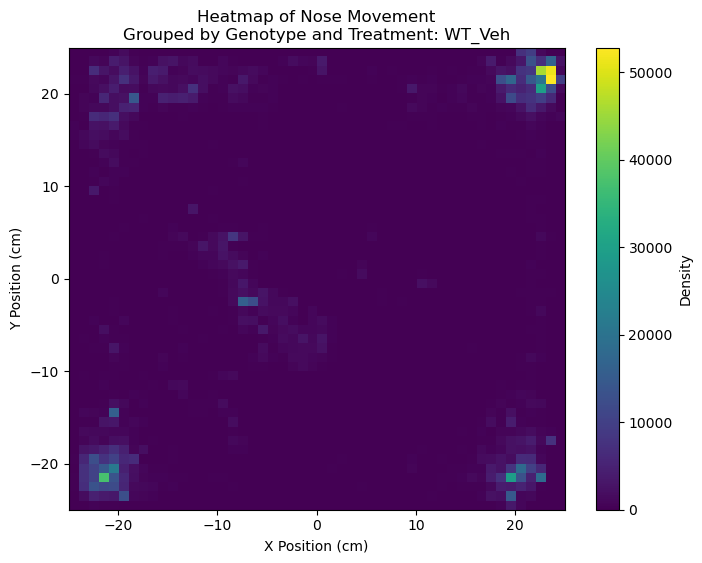

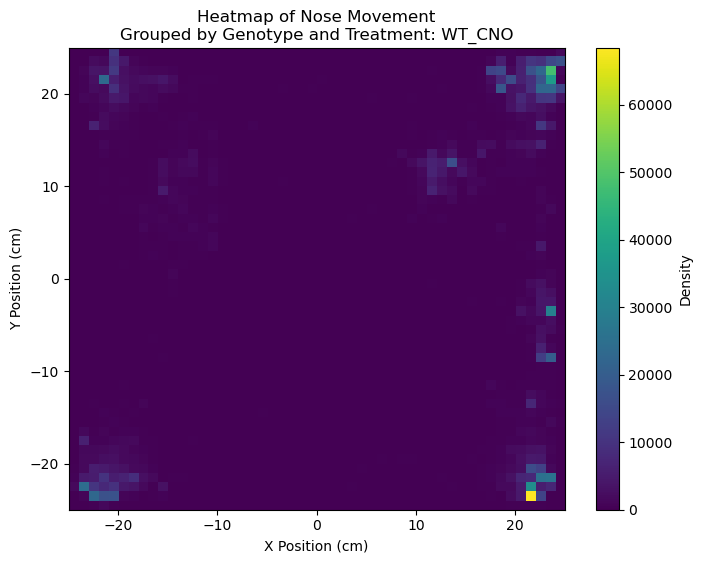

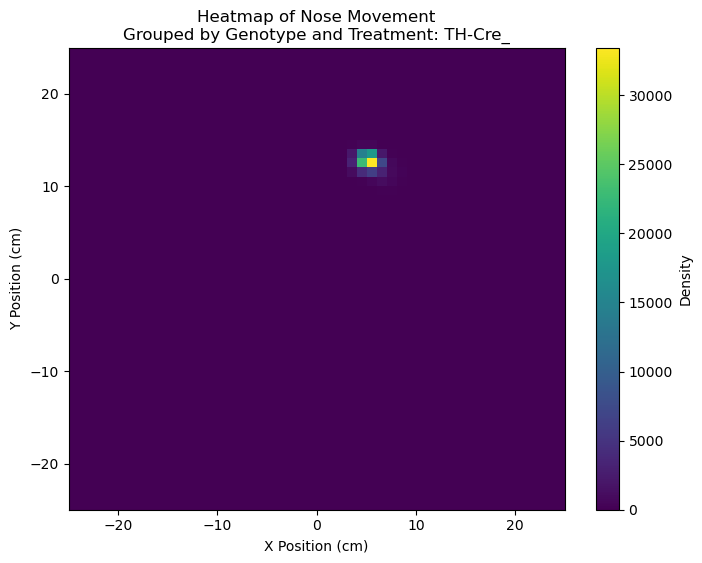

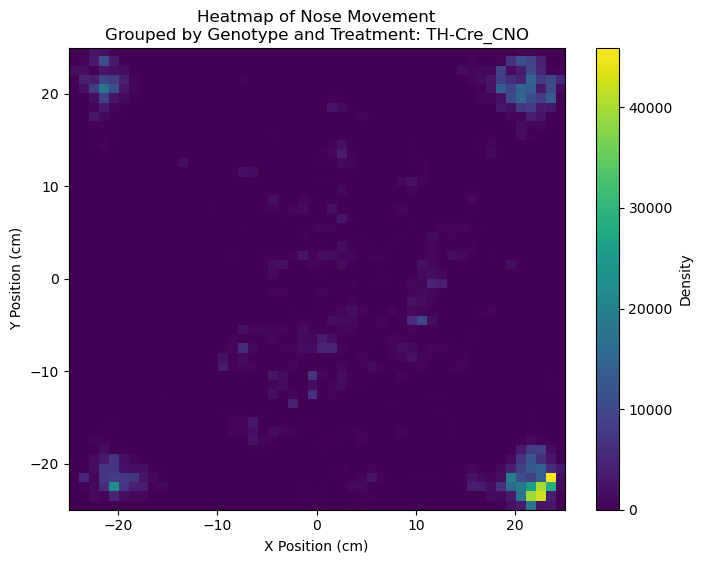

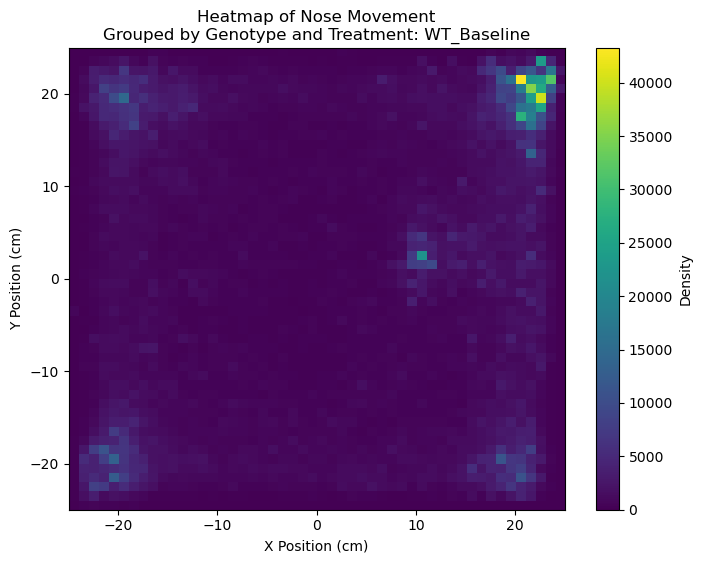

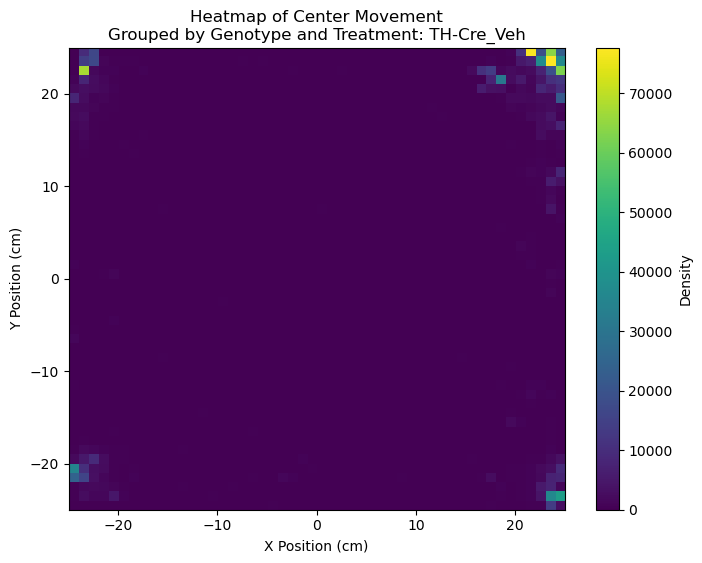

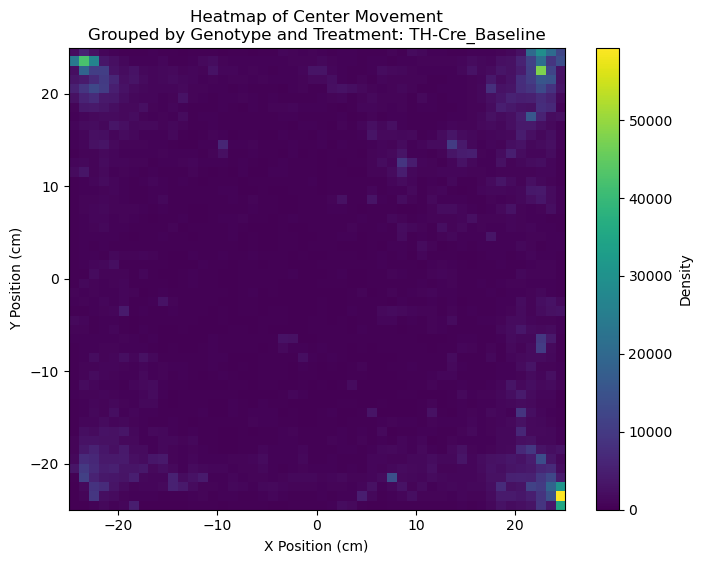

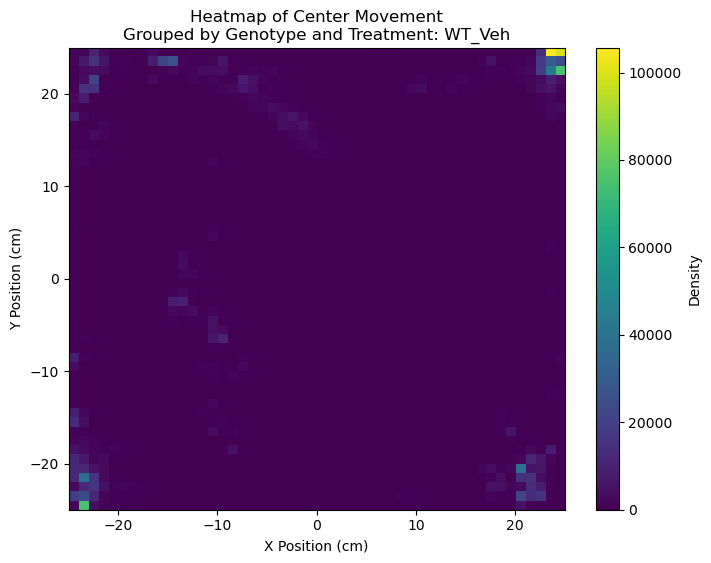

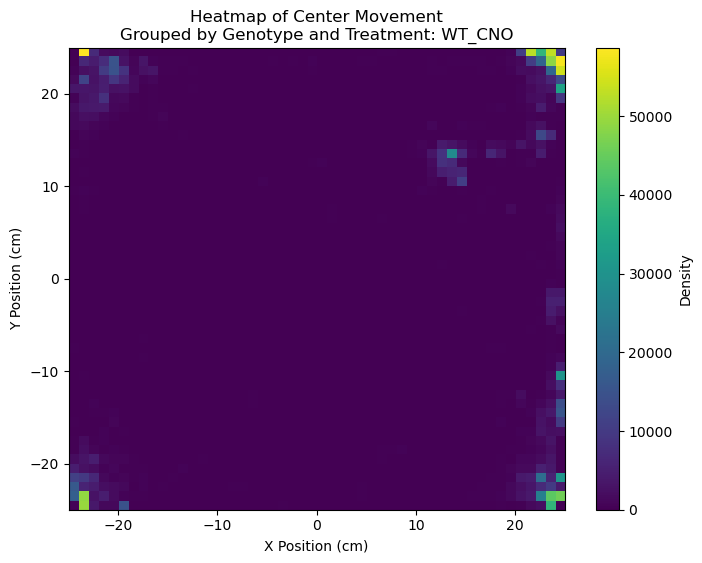

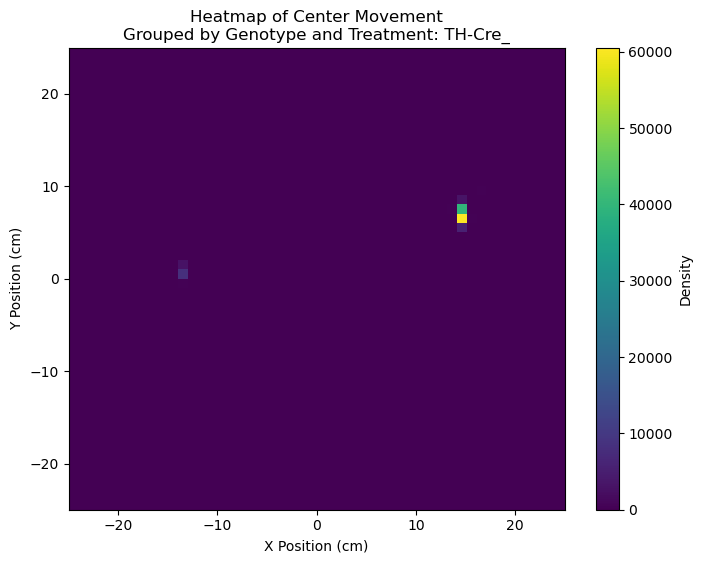

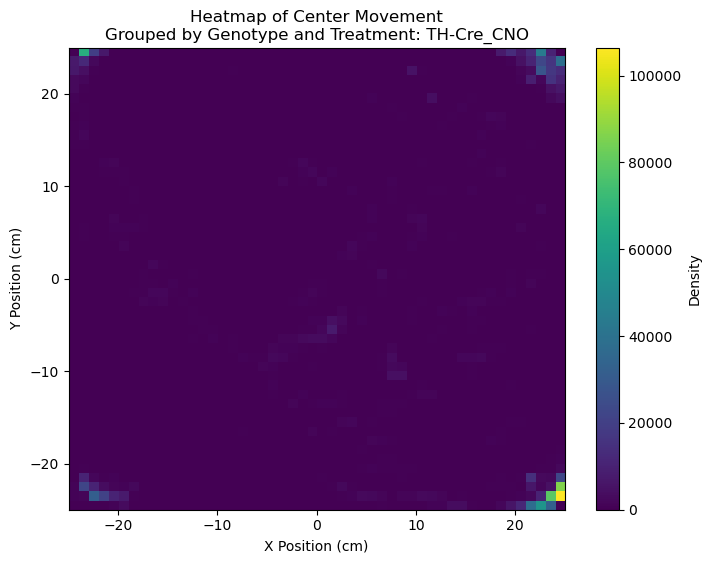

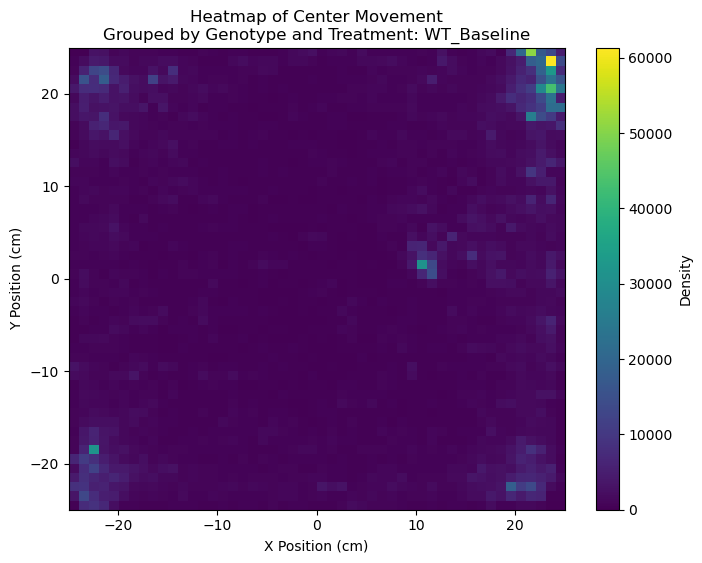

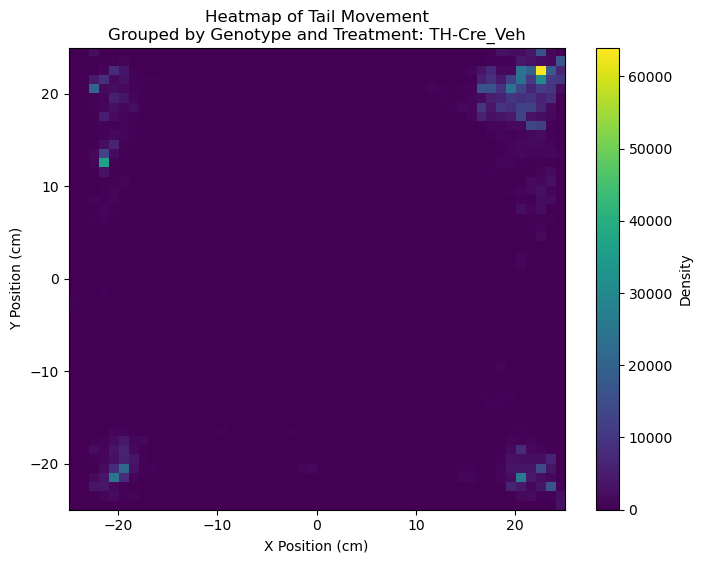

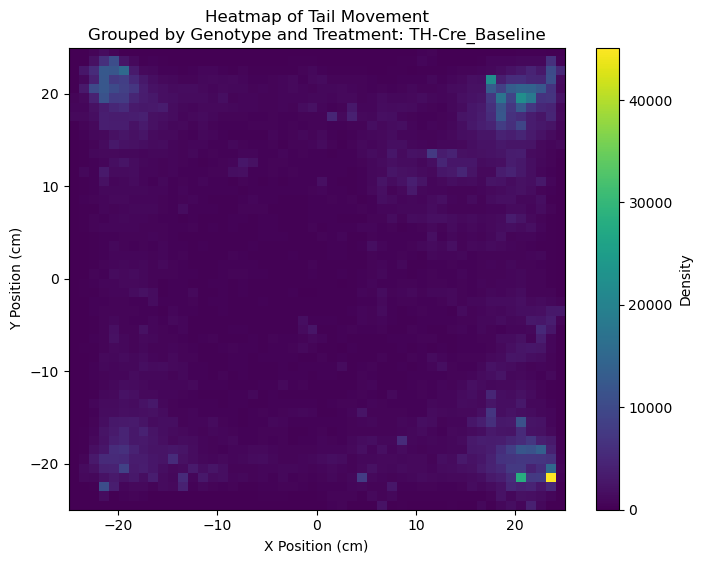

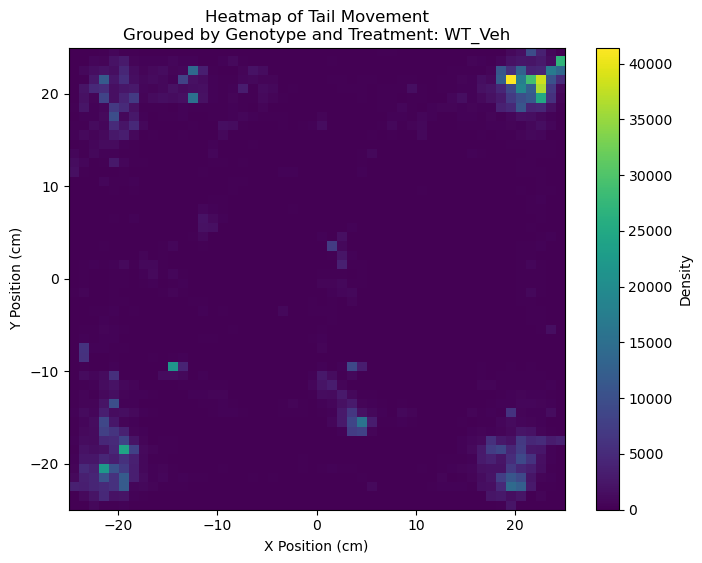

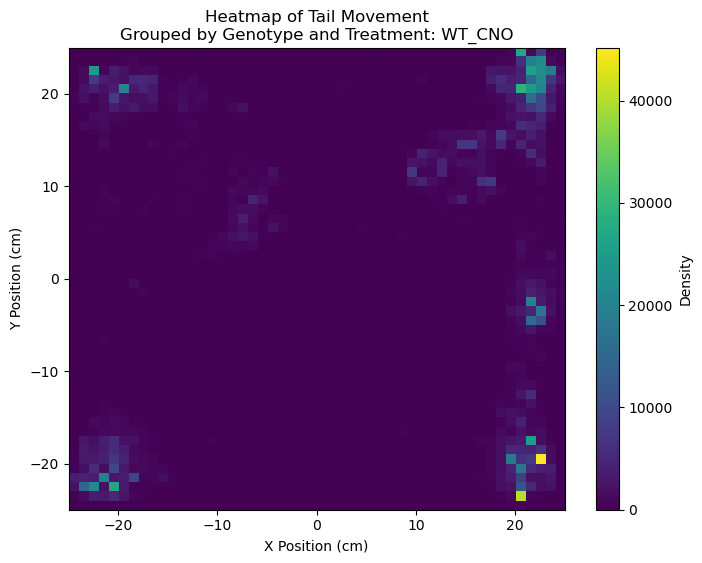

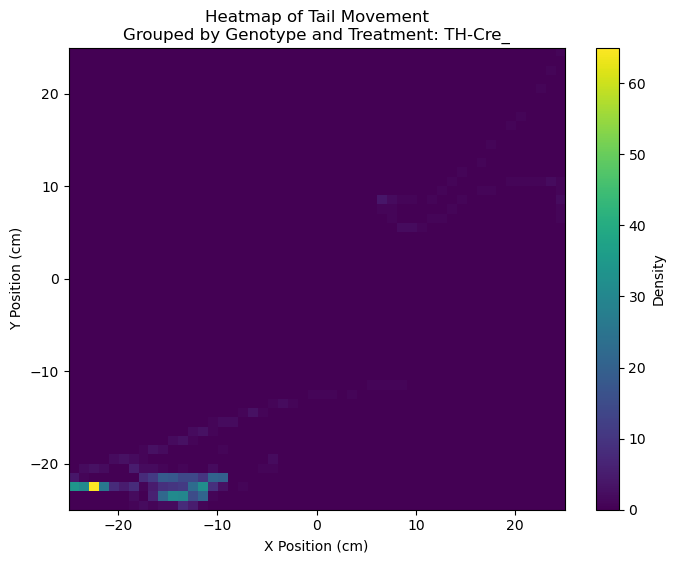

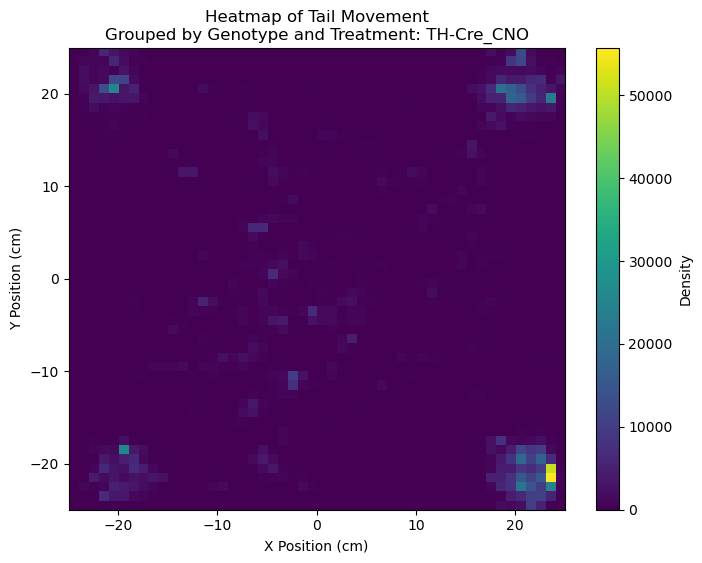

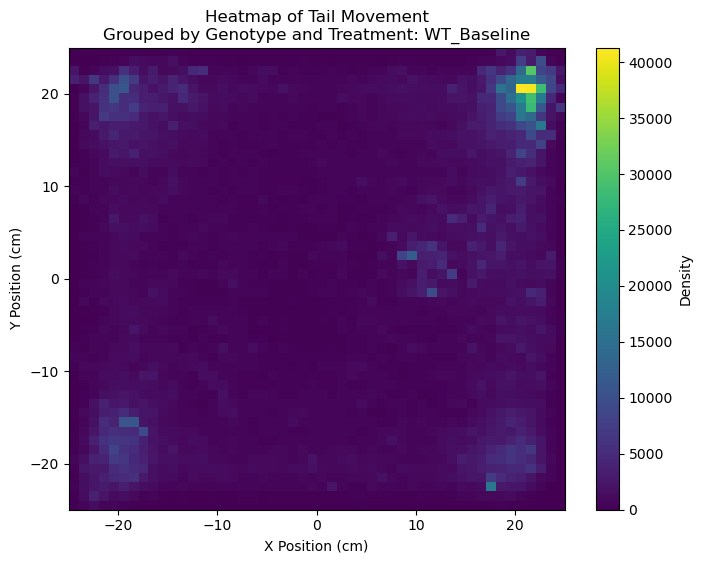

In [91]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_data(df, x_col, y_col, x_min_target=-25, x_max_target=25, y_min_target=-25, y_max_target=25):
    """
    Normalize the X and Y data to fit within the target coordinate range (-25, 25).
    """
    x_data = df[x_col].dropna()
    y_data = df[y_col].dropna()

    # Find the current min and max of the data
    x_min, x_max = x_data.min(), x_data.max()
    y_min, y_max = y_data.min(), y_data.max()

    # Scale the data to fit the target range
    x_data_scaled = (x_data - x_min) / (x_max - x_min) * (x_max_target - x_min_target) + x_min_target
    y_data_scaled = (y_data - y_min) / (y_max - y_min) * (y_max_target - y_min_target) + y_min_target

    return x_data_scaled, y_data_scaled

def create_grouped_heatmap_by_combination(data_store, body_part):
    """
    Create grouped heatmaps based on the combinations of Genotype and Treatment.

    Parameters:
    - data_store: A dictionary containing trial data and headers.
    - body_part: The body part for which to generate the heatmap (e.g., 'nose', 'center', 'tail').
    """

    grouped_data = {}

    # Iterate through the trials and group the X and Y data by Genotype and Treatment combination
    for trial, trial_data in data_store.items():
        trial_df = trial_data['data']
        trial_header = trial_data['header']

        genotype = trial_header['Genotype']
        treatment = trial_header['Treatment']
        group_key = f'{genotype}_{treatment}'  # Combine genotype and treatment as a key

        # Define the X and Y column names based on the body part
        x_col = f'X {body_part} (cm)'
        y_col = f'Y {body_part} (cm)'

        if x_col not in trial_df.columns or y_col not in trial_df.columns:
            continue  # Skip trials that don't have the relevant columns

        # Normalize the data to fit within the target range (-25, 25)
        x_data_scaled, y_data_scaled = normalize_data(trial_df, x_col, y_col)

        # Initialize the group if it doesn't exist
        if group_key not in grouped_data:
            grouped_data[group_key] = {'x': [], 'y': []}

        # Append the scaled data for this trial to the corresponding group
        grouped_data[group_key]['x'].extend(x_data_scaled)
        grouped_data[group_key]['y'].extend(y_data_scaled)

    # Create a heatmap for each combination of Genotype and Treatment
    for group_key, data in grouped_data.items():
        x_data = np.array(data['x'])
        y_data = np.array(data['y'])

        # Create a 2D histogram (heatmap) of the X and Y data
        heatmap, xedges, yedges = np.histogram2d(x_data, y_data, bins=50, range=[[-25, 25], [-25, 25]])

        # Plot the heatmap
        plt.figure(figsize=(8, 6))
        plt.imshow(
            heatmap.T, 
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            origin='lower',
            cmap='viridis',
            aspect='auto'
        )
        plt.colorbar(label='Density')
        plt.title(f'Heatmap of {body_part.capitalize()} Movement\nGrouped by Genotype and Treatment: {group_key}')
        plt.xlabel('X Position (cm)')
        plt.ylabel('Y Position (cm)')
        plt.savefig(f'heatmap_genotype_treatment_{group_key}_{body_part}.png')
        plt.show()

# Example usage:
# Create heatmaps grouped by combinations of Genotype and Treatment for each body part
for body_part in ['nose', 'center', 'tail']:
    create_grouped_heatmap_by_combination(data_store, body_part)
